# First Exploratory Data Analysis of Crypto Data

## Plotting
* Plot data  in diffs
* Plot Correlations in diffs
* ACFs and CCFss in diffs
* Summary Statistics

## Goal: All things needed for a pre-causal analysis

In [2]:
import glob
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from statsmodels.tsa.stattools import acf, ccf, pacf
import plotly.express as px
import plotly.graph_objects as go

# Set style for better visualizations
sns.set_theme()
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [12, 6]

### Functions

In [3]:
# plotting time series data
def plot_time_series_data(data, symbol, column="close", title=None):
    fig = px.line(data[f'{symbol}USDT'], x="timestamp", y=column, title=title)
    fig.show()

In [4]:
def load_and_prepare_data(data_dir="../data/processed/"):
    # Load raw data
    all_data = {}
    returns_data = {}

    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split("_")[0]
        df = pq.read_table(file).to_pandas()

        # Calculate log returns
        df["log_returns"] = np.log(df["close"]/df["close"].shift(1))

        # Calculate simple returns
        df["simple_returns"] = df["close"].pct_change()

        # Calculate absolute difference
        df["price_diff"] = df["close"].diff()

        all_data[symbol] = df
        returns_data[symbol] = df[
            ["timestamp", "log_returns", "simple_returns", "price_diff"]
        ].copy()

    return all_data, returns_data

In [5]:
def plot_acf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot ACF for each cryptocurrency's returns/differences
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    for symbol, df in returns_data.items():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle(f"ACF Analysis of {diff_type} for {symbol}")

        series = df[diff_type].dropna()

        # ACF
        acf_values = acf(series, nlags=max_lags)
        ax1.stem(range(len(acf_values)), acf_values)
        ax1.axhline(y=0, linestyle="-", color="black")
        ax1.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.set_title(f"Autocorrelation Function")

        # PACF
        pacf_values = pacf(series, nlags=max_lags)
        ax2.stem(range(len(pacf_values)), pacf_values)
        ax2.axhline(y=0, linestyle="-", color="black")
        ax2.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.set_title(f"Partial Autocorrelation Function")

        plt.tight_layout()
        plt.show()

In [60]:
def plot_ccf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot CCF between pairs of cryptocurrencies
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values_ylag = ccf(series1, series2, adjusted=False)
        ccf_values_xlag = ccf(series2, series1, adjusted=False)
        ccf_values = np.concatenate([ccf_values_ylag[max_lags:0:-1],ccf_values_xlag[0:max_lags+1]])

        # Plot
        plt.figure(figsize=(15, 5))
        plt.stem(
            range(-max_lags, max_lags + 1),
            ccf_values  # +ve lag is when series1 leads series2 (y can be predicted by x)
        )
        plt.axhline(y=0, linestyle="-", color="black")
        plt.axhline(y=1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")
        plt.axhline(y=-1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")

        plt.title(f"Cross-Correlation of {diff_type}: {symbol1} vs {symbol2} (+ve lag: {symbol1} leads indicator for {symbol2})")
        plt.xlabel("Lag")
        plt.ylabel("CCF")

        # Find significant lags
        threshold = 1.96 / np.sqrt(len(series1))
        sig_lags = np.where(np.abs(ccf_values) > threshold)[0] - max_lags
        if len(sig_lags) > 0:
            print(f"\nSignificant lags between {symbol1} and {symbol2}:")
            for lag in sig_lags:
                corr = ccf_values[lag + max_lags]
                if lag < 0:
                    print(
                        f"{symbol2} leads {symbol1} by {abs(lag)} periods "
                        f"(correlation: {corr:.3f})"
                    )
                elif lag > 0:
                    print(
                        f"{symbol1} leads {symbol2} by {lag} periods "
                        f"(correlation: {corr:.3f})"
                    )

        plt.tight_layout()
        plt.show()

In [75]:
def create_lead_lag_summary(returns_data, diff_type='log_returns', lags=50):
    summary_data = []

    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values_ylag = ccf(series1, series2, adjusted=False)
        ccf_values_xlag = ccf(series2, series1, adjusted=False)
        ccf_values = np.concatenate([ccf_values_ylag[max_lags:0:-1],ccf_values_xlag[1:max_lags+1]])

        # Find max correlation and corresponding lag and excluding coincident values
        max_corr_idx = np.argmax(np.abs(ccf_values))
        max_corr = ccf_values[max_corr_idx]
        max_lag = max_corr_idx - lags

        if max_lag < 0:
            leader = symbol2
            lagger = symbol1
            lag = abs(max_lag)
        else:
            leader = symbol1
            lagger = symbol2
            lag = max_lag

        summary_data.append({
            'Leader': leader,
            'Lagger': lagger,
            'Lag (minutes)': lag,
            'Correlation': max_corr
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df.sort_values('Correlation', key=abs, ascending=False)
    

In [81]:
def plot_returns_distribution(returns_data, diff_type="log_returns"):
    plt.figure(figsize=(15, 5))

    for symbol, df in returns_data.items():
        sns.kdeplot(data=df[diff_type].dropna(), label=symbol)

    plt.title(f"Distribution of {diff_type}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [84]:
def plot_qq_normal(returns_data, diff_type="log_returns"):
    """Create QQ plots comparing each cryptocurrency's returns to normal distribution."""

    n_symbols = len(returns_data)
    n_cols = 2
    n_rows = (n_symbols + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots vs Normal Distribution", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    if n_rows > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes] if n_cols == 1 else axes

    for (symbol, returns), ax in zip(returns_data.items(), axes_flat):
        # Get the return series
        returns = returns[diff_type].dropna()

        # Standardize returns
        standardized_returns = (returns - returns.mean()) / returns.std()

        # Create QQ plot
        stats.probplot(standardized_returns, dist="norm", plot=ax)
        ax.set_title(f"{symbol} Returns vs Normal Distribution")

        # Calculate and display Shapiro-Wilk test
        stat, p_value = stats.shapiro(standardized_returns)
        ax.text(
            0.05,
            0.95,
            f"Shapiro-Wilk p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(returns_data), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()
    

In [83]:
def plot_qq_pairs(returns_data, diff_type="log_returns"):
    """Create QQ plots comparing returns distributions between pairs of cryptocurrencies."""
    pairs = list(itertools.combinations(returns_data.keys(), 2))
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = (n_pairs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots Between Cryptocurrency Pairs", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for (symbol1, symbol2), ax in zip(pairs, axes_flat):
        returns1 = returns_data[symbol1][diff_type].dropna()
        returns2 = returns_data[symbol2][diff_type].dropna()

        # Standardize both return series
        std_returns1 = (returns1 - returns1.mean()) / returns1.std()
        std_returns2 = (returns2 - returns2.mean()) / returns2.std()

        # Get common length
        min_len = min(len(std_returns1), len(std_returns2))
        std_returns1 = std_returns1[:min_len]
        std_returns2 = std_returns2[:min_len]

        # Sort both series
        sorted1 = np.sort(std_returns1)
        sorted2 = np.sort(std_returns2)

        # Create QQ plot
        ax.scatter(sorted1, sorted2, alpha=0.5)

        # Add diagonal line
        min_val = min(sorted1.min(), sorted2.min())
        max_val = max(sorted1.max(), sorted2.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--")

        ax.set_title(f"QQ Plot: {symbol1} vs {symbol2}")
        ax.set_xlabel(f"{symbol1} Standardized Returns")
        ax.set_ylabel(f"{symbol2} Standardized Returns")

        # Calculate and display Kolmogorov-Smirnov test
        ks_stat, p_value = stats.ks_2samp(std_returns1, std_returns2)
        ax.text(
            0.05,
            0.95,
            f"KS test p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(pairs), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()
    

In [ ]:
def print_distribution_stats(returns_data, diff_type="log_returns"):
    """Print summary statistics about the distribution of returns."""
    stats_df = pd.DataFrame(
        columns=["Mean", "Std", "Skewness", "Kurtosis", "Shapiro-Wilk p-value"]
    )

    for symbol, returns in returns_data.items():
        # Get the return series
        returns = returns[diff_type].dropna()

        # Standardize returns
        std_returns = (returns - returns.mean()) / returns.std()

        # Calculate statistics
        sw_stat, sw_p = stats.shapiro(std_returns)

        stats_df.loc[symbol] = [
            returns.mean(),
            returns.std(),
            stats.skew(returns),
            stats.kurtosis(returns),  # Fisher kurtosis (normal = 0)
            sw_p,
        ]

    print("\nDistribution Statistics:")
    print(stats_df)


print_distribution_stats(returns_data)


1        0.926405
2        0.134911
3        1.583119
4        1.448658
5       -1.968779
           ...   
44636    0.475028
44637    0.003099
44638   -1.098511
44639   -0.311931
44640    0.475597
Name: log_returns, Length: 44640, dtype: float64


AttributeError: 'Series' object has no attribute 'shapiro'

### Plot timeseries data

In [61]:
# Load data
all_data, returns_data = load_and_prepare_data()
plot_time_series_data(all_data, "BTC", title="BTC Close Price")


In [71]:
# Summary Statistics
summary_stats = pd.DataFrame()
for symbol, returns in returns_data.items():
    stats = returns['log_returns'].describe()
    stats['skewness'] = returns['log_returns'].skew()
    stats['kurtosis'] = returns['log_returns'].kurtosis()
    summary_stats[symbol] = stats

print("\nSummary Statistics for Returns:")
print(summary_stats)



Summary Statistics for Returns:
               ADAUSDT       BNBUSDT       BTCUSDT      DOGEUSDT  \
count     44640.000000  4.464000e+04  4.464000e+04  44640.000000   
mean         -0.000004 -8.261214e-07  1.763238e-07     -0.000003   
std           0.001276  9.118501e-04  8.059727e-04      0.001179   
min          -0.049435 -2.952364e-02 -2.735821e-02     -0.054418   
25%          -0.000602 -3.303055e-04 -3.163289e-04     -0.000482   
50%           0.000000  0.000000e+00  0.000000e+00      0.000000   
75%           0.000593  3.300875e-04  3.231704e-04      0.000478   
max           0.025432  3.608718e-02  1.501286e-02      0.054653   
skewness     -3.229180  2.590119e-01 -3.173194e+00     -2.799927   
kurtosis    132.429948  1.204319e+02  1.238676e+02    383.833120   

               ETHUSDT       XRPUSDT  
count     4.464000e+04  44640.000000  
mean      4.246179e-08     -0.000004  
std       8.247499e-04      0.001082  
min      -2.973708e-02     -0.083560  
25%      -3.554860e-04 

## Cross-Correlation Analysis

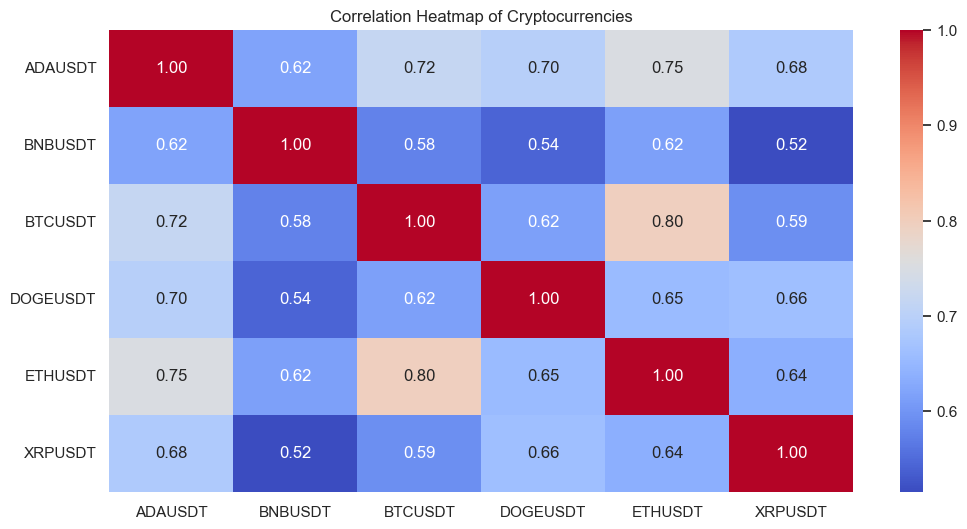

In [62]:
# Create a combined returns dataframe
combined_returns = pd.DataFrame()
for symbol, returns in returns_data.items():
    combined_returns[symbol] = returns['log_returns']
combined_returns.index = list(returns_data.values())[0]['timestamp']

# plot correlation heatmap
corr = combined_returns.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Cryptocurrencies")
plt.show()


ACF Analysis of Log Returns


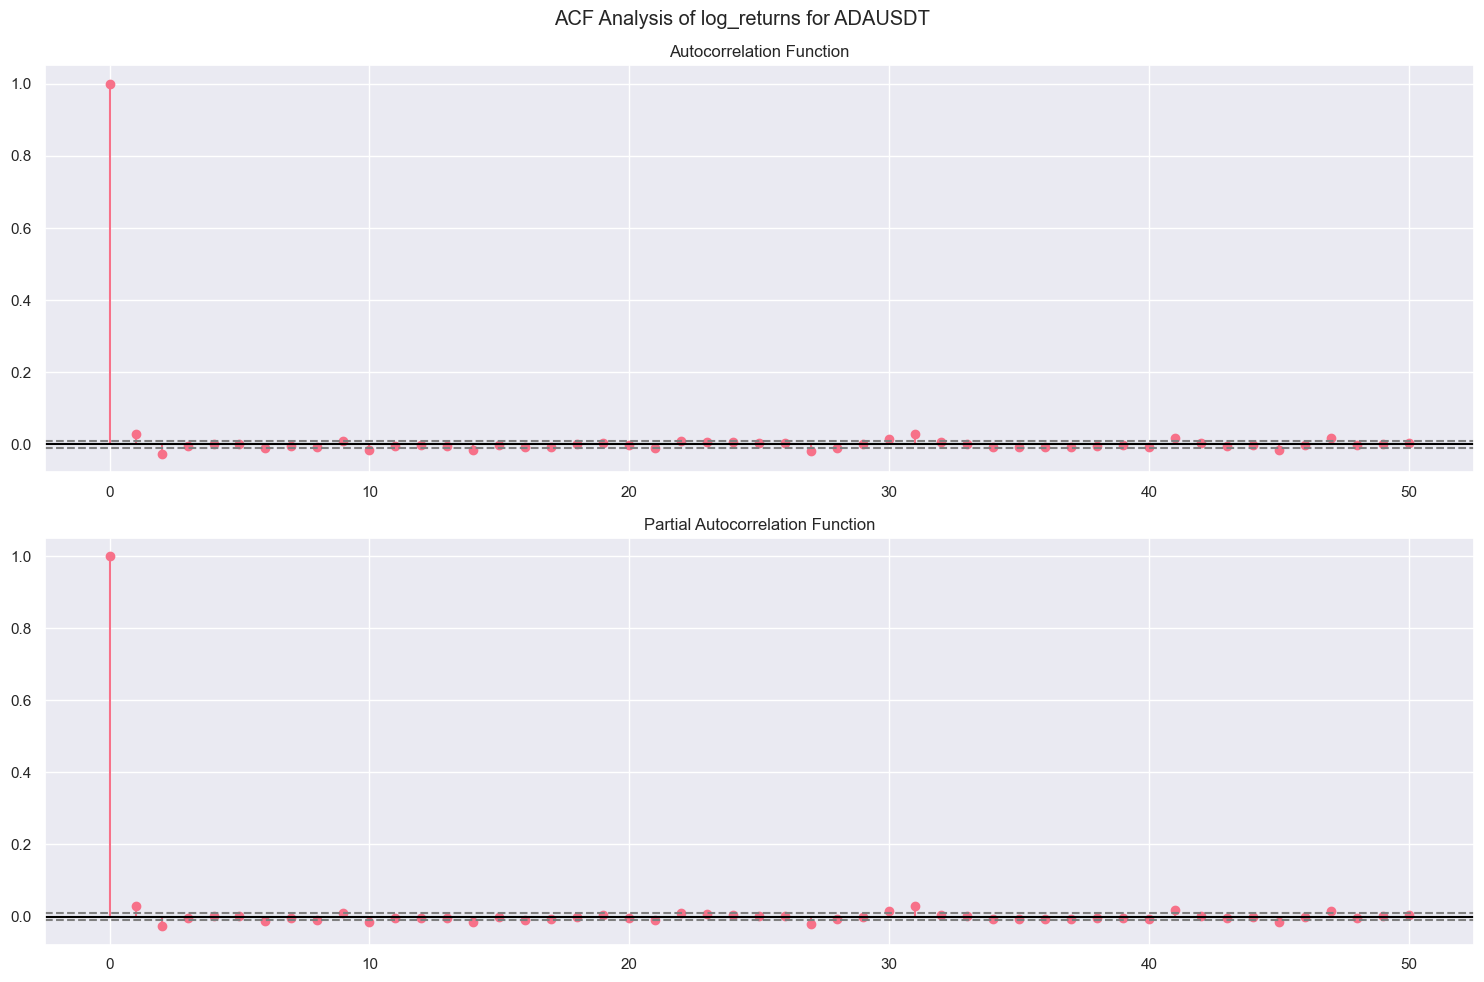

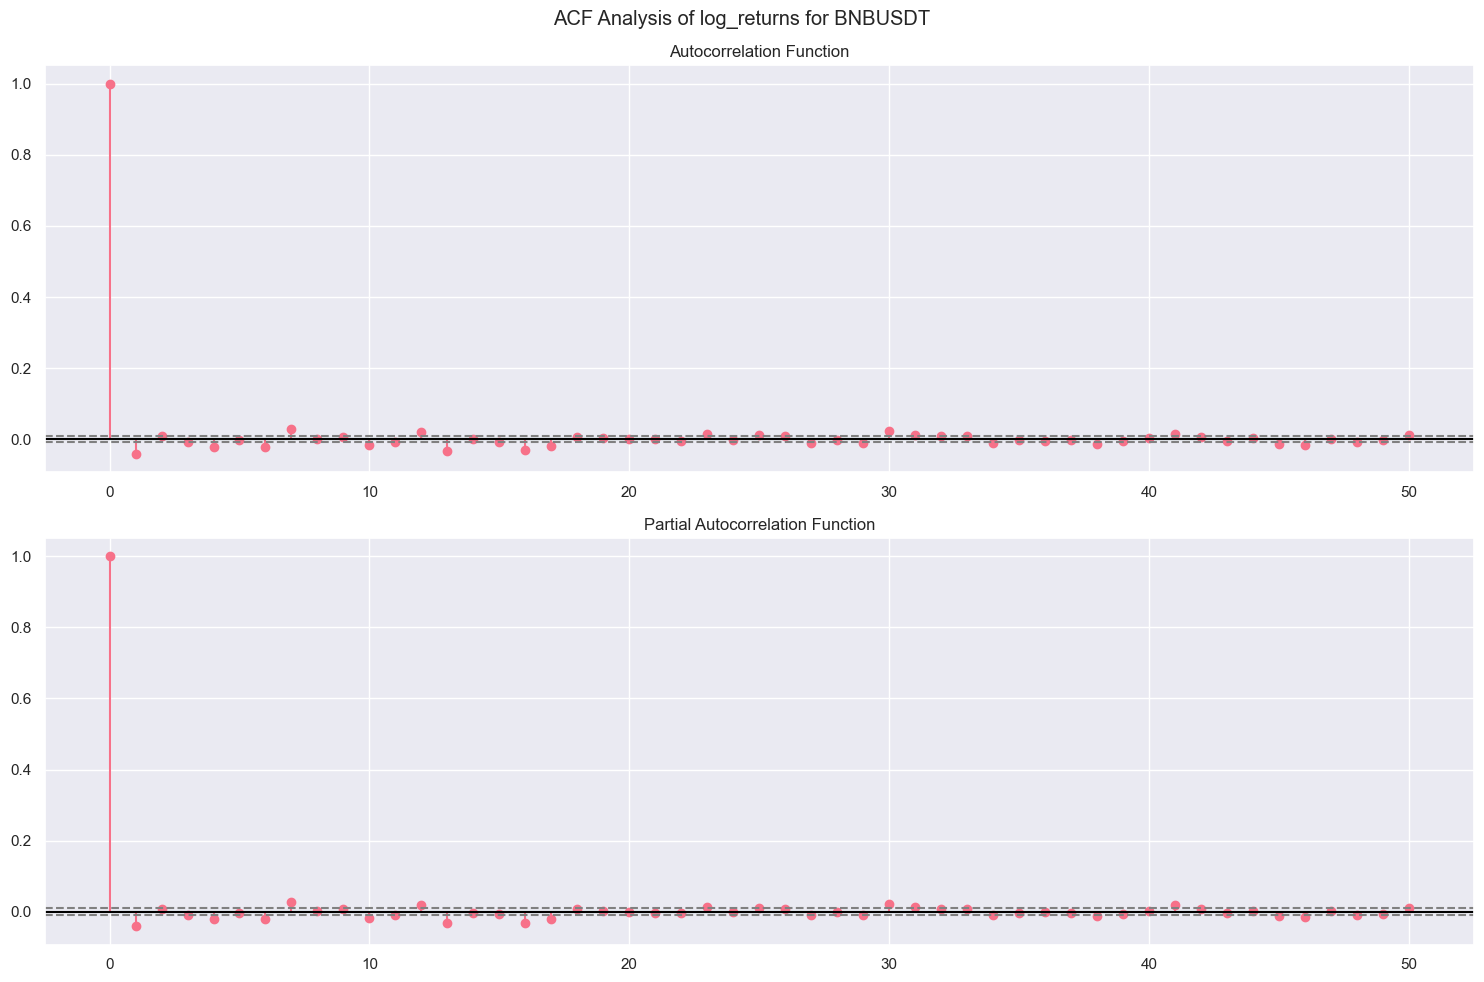

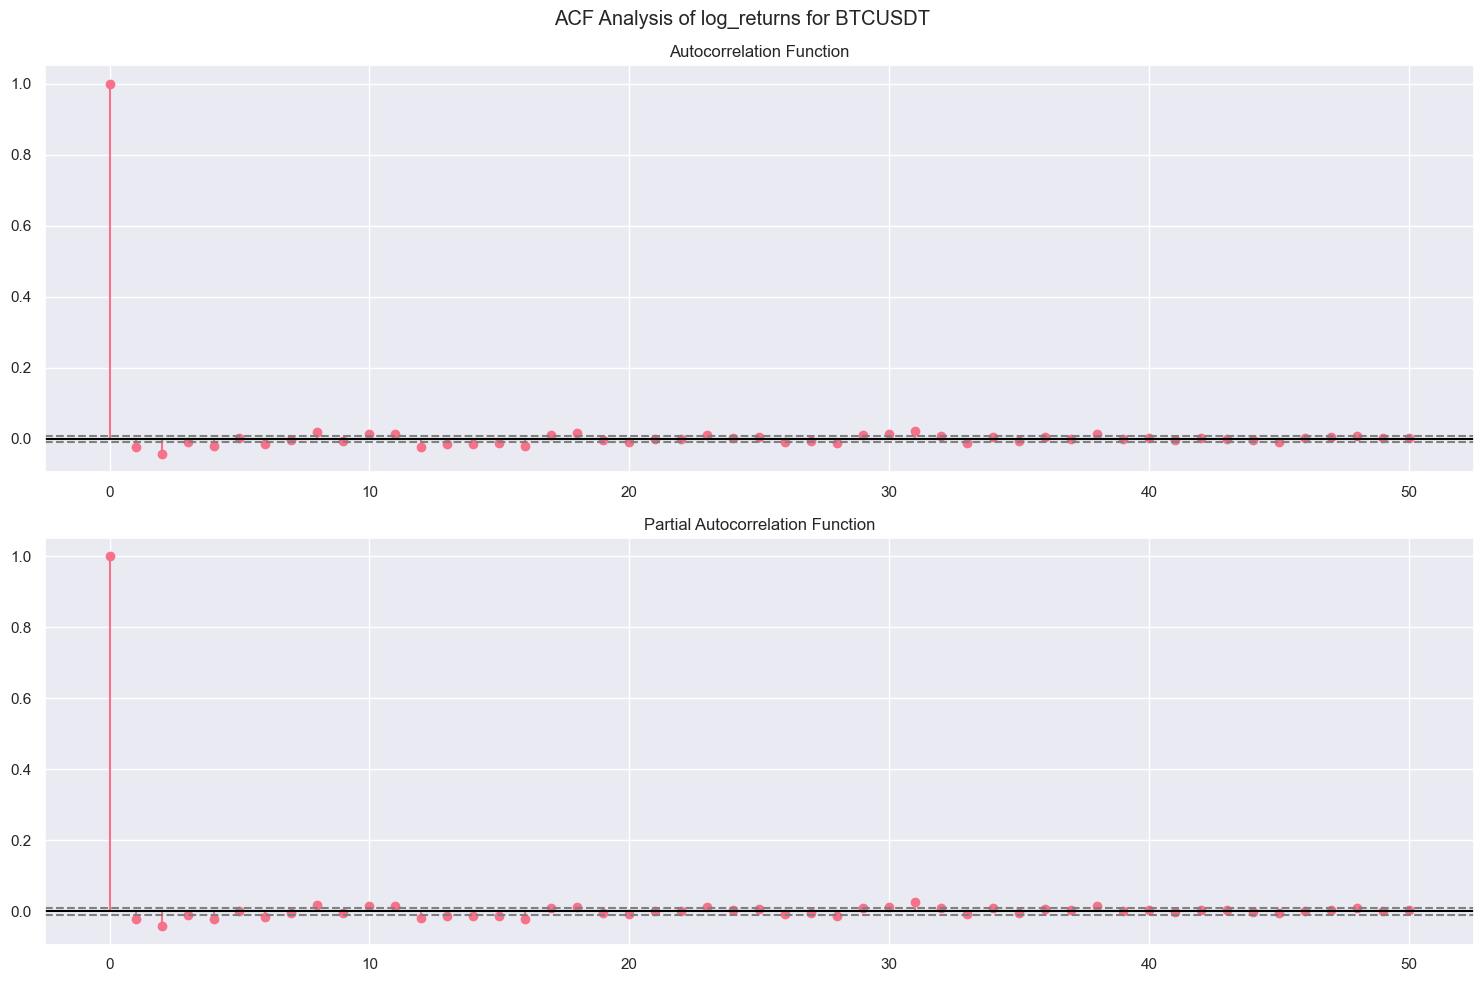

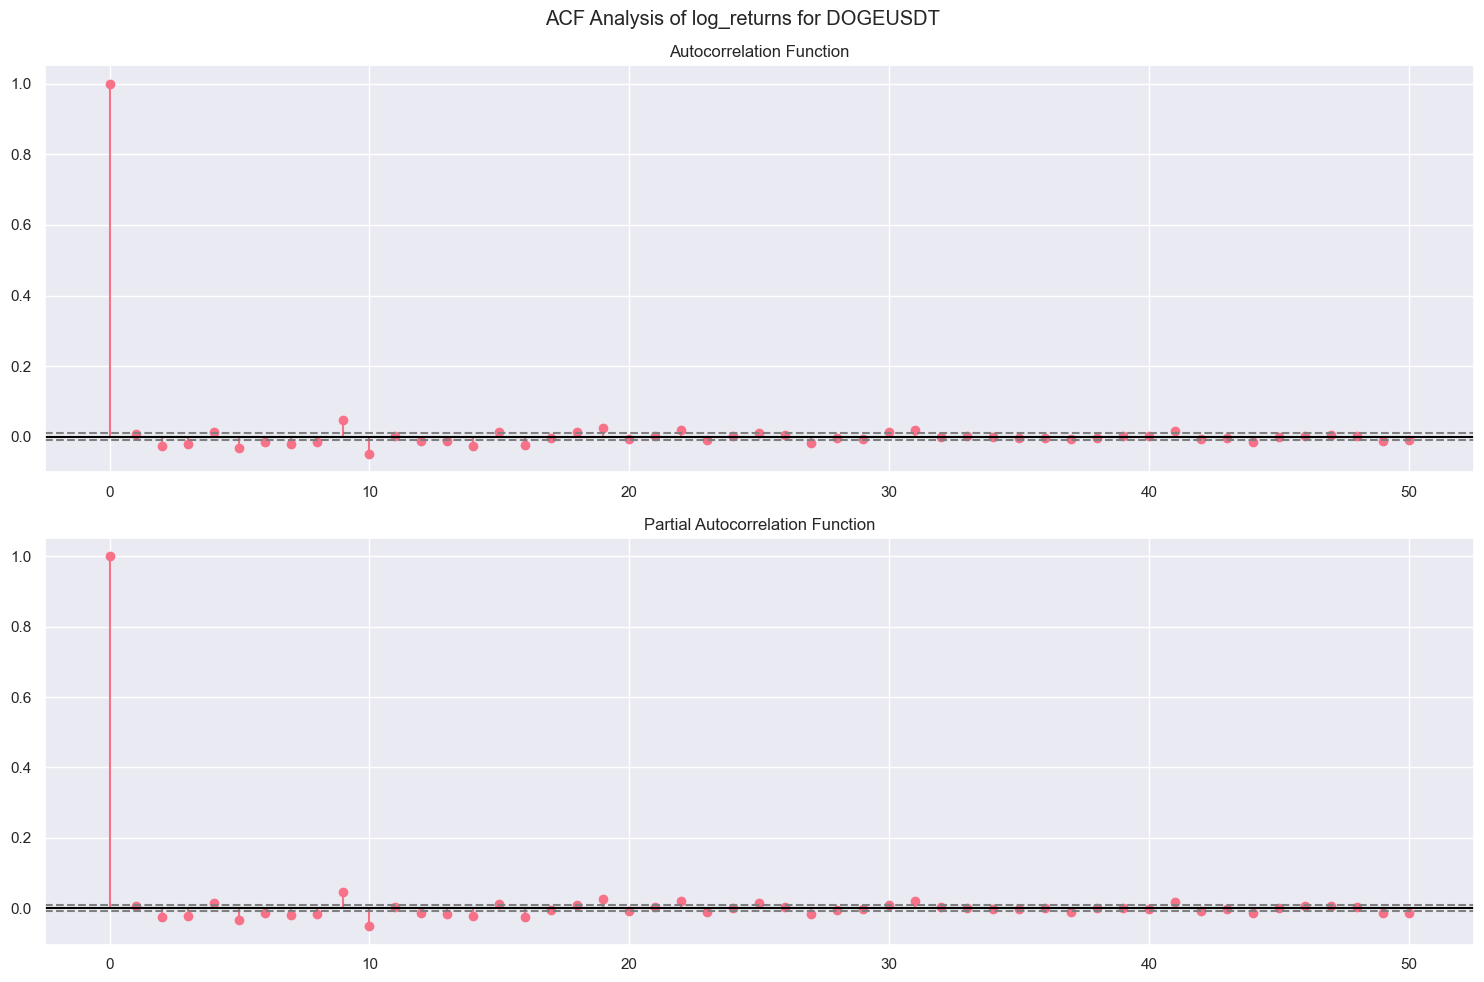

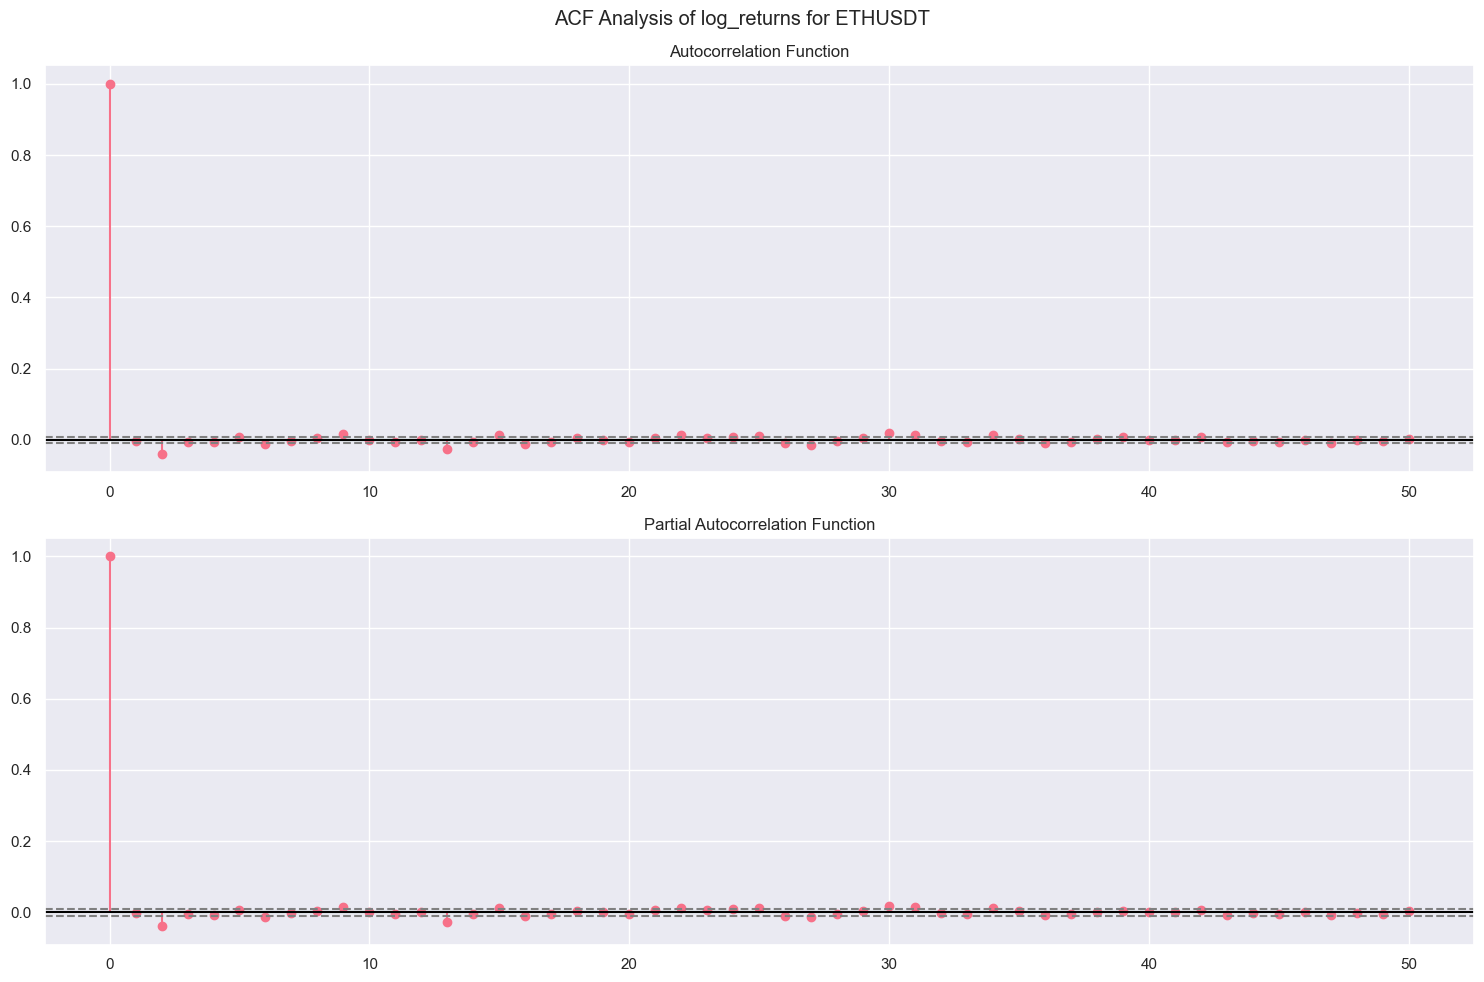

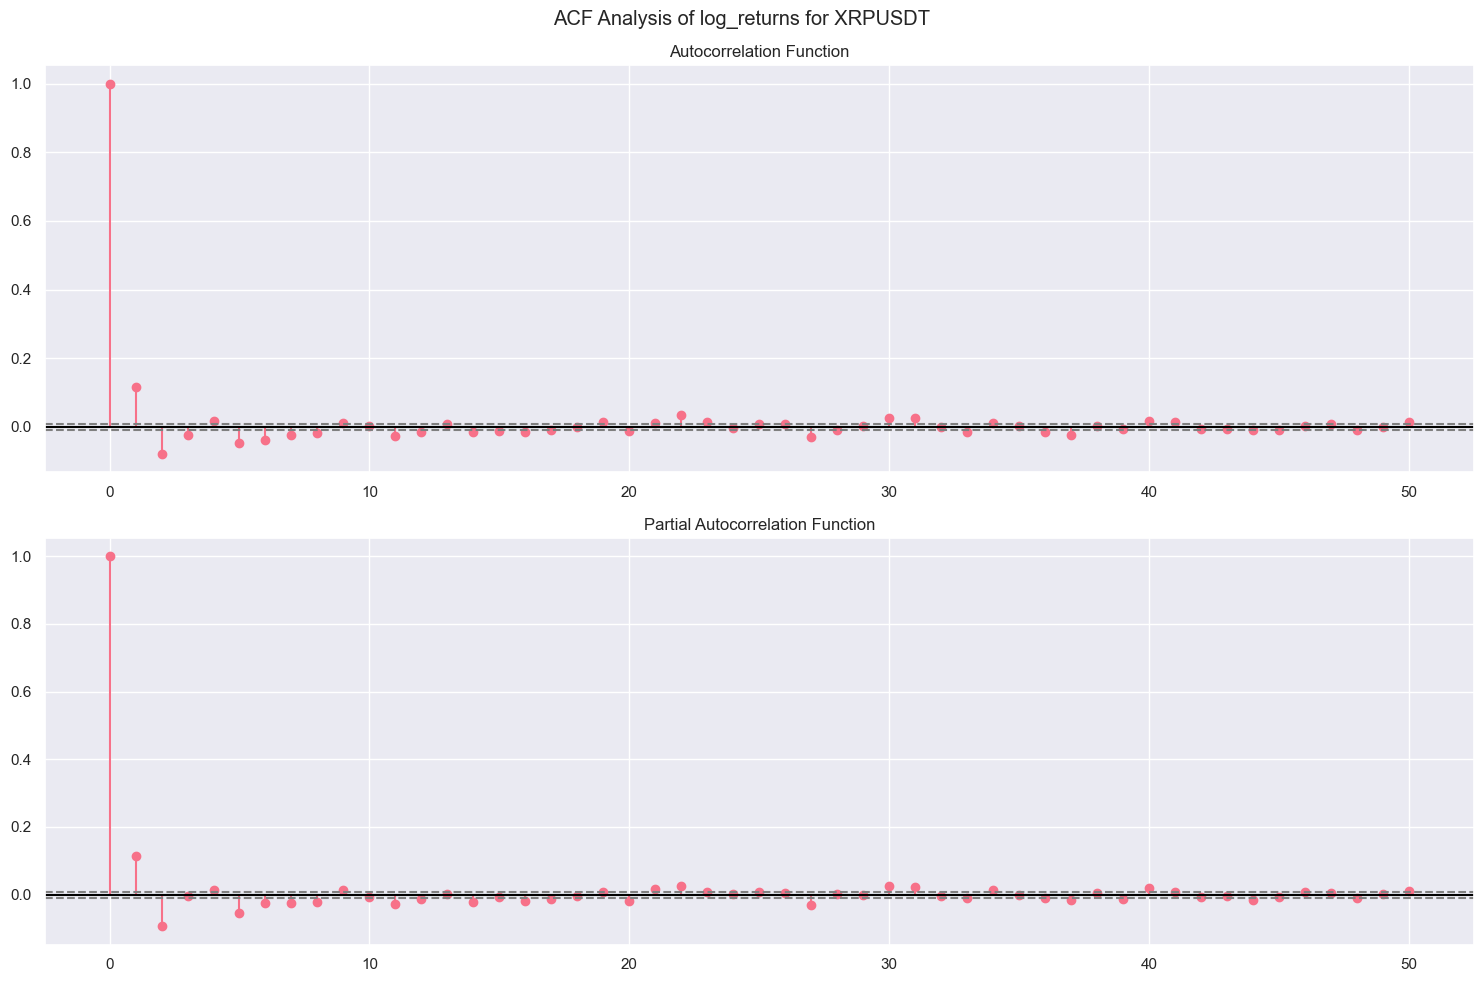


CCF Analysis of Log Returns

Significant lags between ADAUSDT and BNBUSDT:
BNBUSDT leads ADAUSDT by 47 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 45 periods (correlation: -0.017)
BNBUSDT leads ADAUSDT by 41 periods (correlation: 0.016)
BNBUSDT leads ADAUSDT by 35 periods (correlation: -0.012)
BNBUSDT leads ADAUSDT by 34 periods (correlation: -0.010)
BNBUSDT leads ADAUSDT by 31 periods (correlation: 0.017)
BNBUSDT leads ADAUSDT by 30 periods (correlation: 0.021)
BNBUSDT leads ADAUSDT by 28 periods (correlation: -0.014)
BNBUSDT leads ADAUSDT by 27 periods (correlation: -0.011)
BNBUSDT leads ADAUSDT by 24 periods (correlation: 0.013)
BNBUSDT leads ADAUSDT by 23 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 19 periods (correlation: 0.012)
BNBUSDT leads ADAUSDT by 16 periods (correlation: -0.018)
BNBUSDT leads ADAUSDT by 9 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 1 periods (correlation: 0.045)
ADAUSDT leads BNBUSDT by 1 periods (correlation: 0.032)
ADAUSDT l

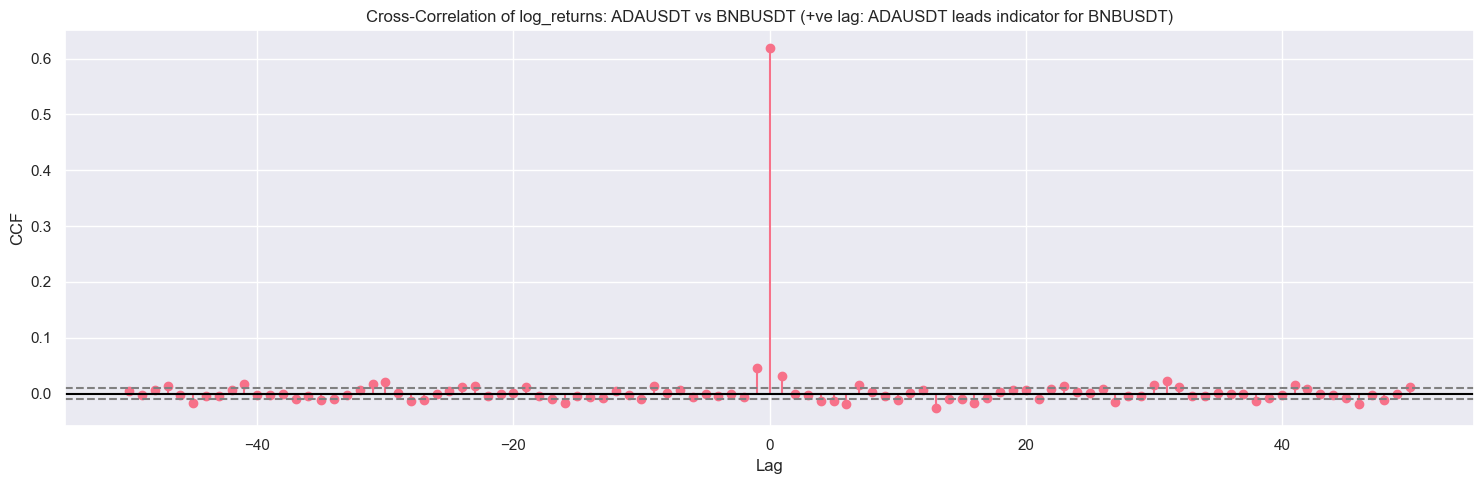


Significant lags between ADAUSDT and BTCUSDT:
BTCUSDT leads ADAUSDT by 47 periods (correlation: 0.013)
BTCUSDT leads ADAUSDT by 45 periods (correlation: -0.012)
BTCUSDT leads ADAUSDT by 41 periods (correlation: 0.010)
BTCUSDT leads ADAUSDT by 38 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 31 periods (correlation: 0.020)
BTCUSDT leads ADAUSDT by 30 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 28 periods (correlation: -0.014)
BTCUSDT leads ADAUSDT by 26 periods (correlation: -0.011)
BTCUSDT leads ADAUSDT by 23 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 16 periods (correlation: -0.017)
BTCUSDT leads ADAUSDT by 9 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 7 periods (correlation: 0.011)
BTCUSDT leads ADAUSDT by 6 periods (correlation: -0.013)
BTCUSDT leads ADAUSDT by 2 periods (correlation: -0.025)
BTCUSDT leads ADAUSDT by 1 periods (correlation: 0.043)
ADAUSDT leads BTCUSDT by 2 periods (correlation: -0.052)
ADAUSDT leads BTCUSDT by 3 periods (corr

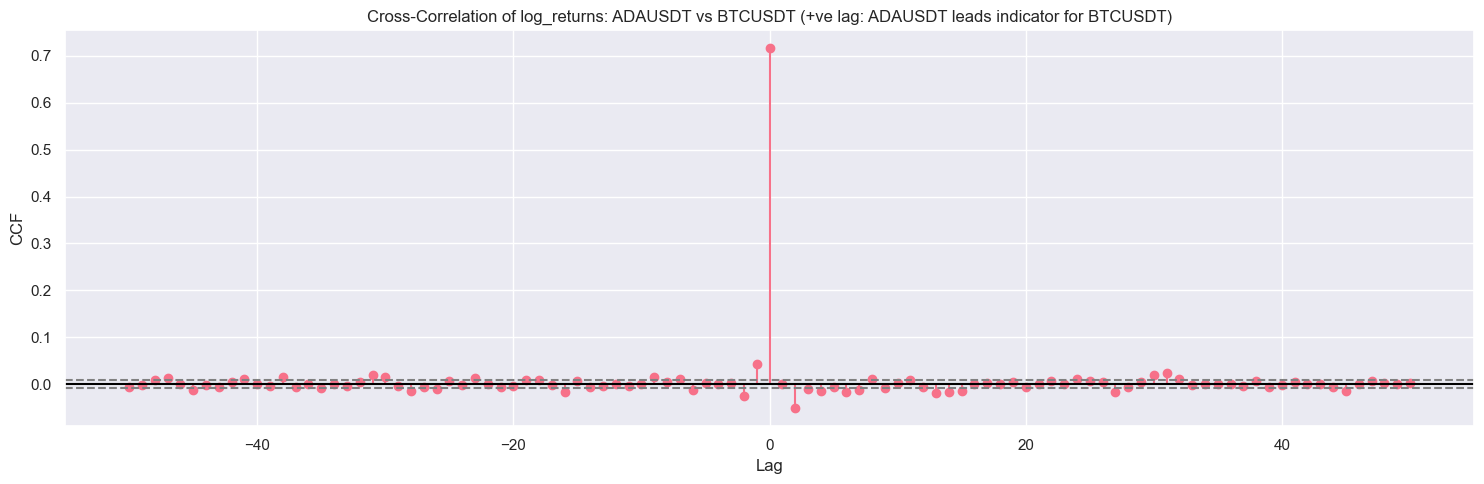


Significant lags between ADAUSDT and DOGEUSDT:
DOGEUSDT leads ADAUSDT by 47 periods (correlation: 0.009)
DOGEUSDT leads ADAUSDT by 41 periods (correlation: 0.015)
DOGEUSDT leads ADAUSDT by 36 periods (correlation: -0.012)
DOGEUSDT leads ADAUSDT by 31 periods (correlation: 0.025)
DOGEUSDT leads ADAUSDT by 30 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 27 periods (correlation: -0.028)
DOGEUSDT leads ADAUSDT by 22 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 18 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 16 periods (correlation: -0.014)
DOGEUSDT leads ADAUSDT by 14 periods (correlation: -0.018)
DOGEUSDT leads ADAUSDT by 10 periods (correlation: -0.013)
DOGEUSDT leads ADAUSDT by 9 periods (correlation: 0.024)
DOGEUSDT leads ADAUSDT by 6 periods (correlation: -0.029)
DOGEUSDT leads ADAUSDT by 5 periods (correlation: -0.010)
DOGEUSDT leads ADAUSDT by 4 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 2 periods (correlation: -0.025)
DOGEUSDT leads ADAUSD

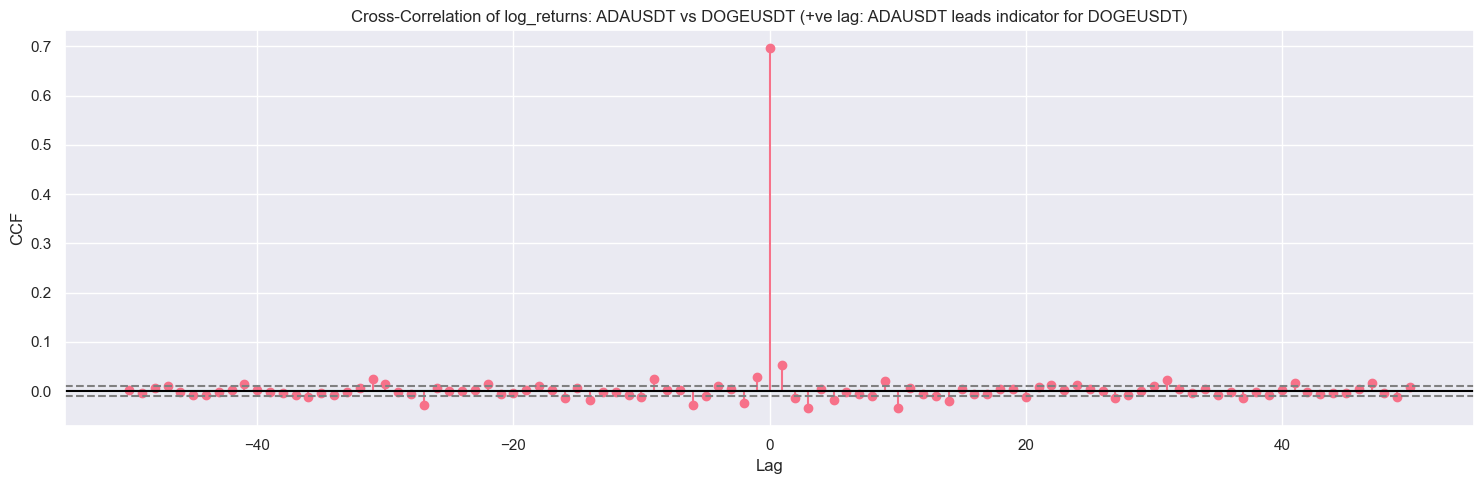


Significant lags between ADAUSDT and ETHUSDT:
ETHUSDT leads ADAUSDT by 45 periods (correlation: -0.011)
ETHUSDT leads ADAUSDT by 41 periods (correlation: 0.013)
ETHUSDT leads ADAUSDT by 31 periods (correlation: 0.020)
ETHUSDT leads ADAUSDT by 30 periods (correlation: 0.014)
ETHUSDT leads ADAUSDT by 28 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 27 periods (correlation: -0.017)
ETHUSDT leads ADAUSDT by 23 periods (correlation: 0.015)
ETHUSDT leads ADAUSDT by 20 periods (correlation: -0.013)
ETHUSDT leads ADAUSDT by 16 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 14 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 10 periods (correlation: -0.016)
ETHUSDT leads ADAUSDT by 9 periods (correlation: 0.017)
ETHUSDT leads ADAUSDT by 7 periods (correlation: 0.012)
ETHUSDT leads ADAUSDT by 6 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 4 periods (correlation: 0.013)
ETHUSDT leads ADAUSDT by 2 periods (correlation: -0.023)
ETHUSDT leads ADAUSDT by 1 periods (c

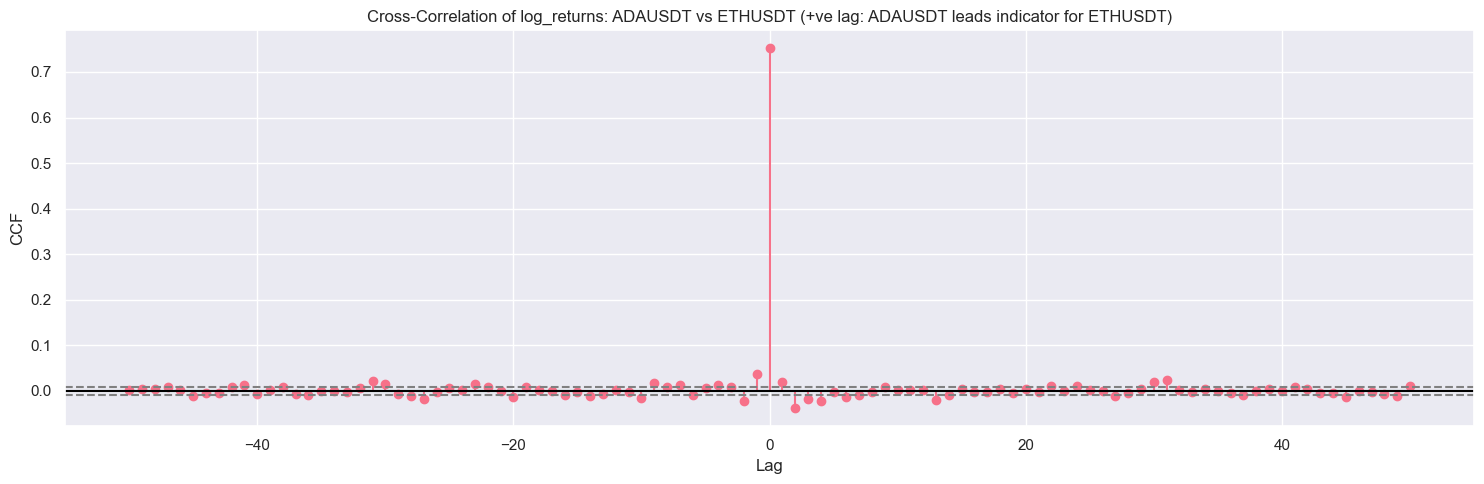


Significant lags between ADAUSDT and XRPUSDT:
XRPUSDT leads ADAUSDT by 50 periods (correlation: 0.015)
XRPUSDT leads ADAUSDT by 47 periods (correlation: 0.013)
XRPUSDT leads ADAUSDT by 45 periods (correlation: -0.023)
XRPUSDT leads ADAUSDT by 44 periods (correlation: -0.012)
XRPUSDT leads ADAUSDT by 43 periods (correlation: -0.011)
XRPUSDT leads ADAUSDT by 41 periods (correlation: 0.016)
XRPUSDT leads ADAUSDT by 37 periods (correlation: -0.016)
XRPUSDT leads ADAUSDT by 36 periods (correlation: -0.019)
XRPUSDT leads ADAUSDT by 31 periods (correlation: 0.021)
XRPUSDT leads ADAUSDT by 30 periods (correlation: 0.028)
XRPUSDT leads ADAUSDT by 28 periods (correlation: -0.010)
XRPUSDT leads ADAUSDT by 27 periods (correlation: -0.020)
XRPUSDT leads ADAUSDT by 26 periods (correlation: -0.012)
XRPUSDT leads ADAUSDT by 23 periods (correlation: 0.014)
XRPUSDT leads ADAUSDT by 22 periods (correlation: 0.022)
XRPUSDT leads ADAUSDT by 20 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 14 peri

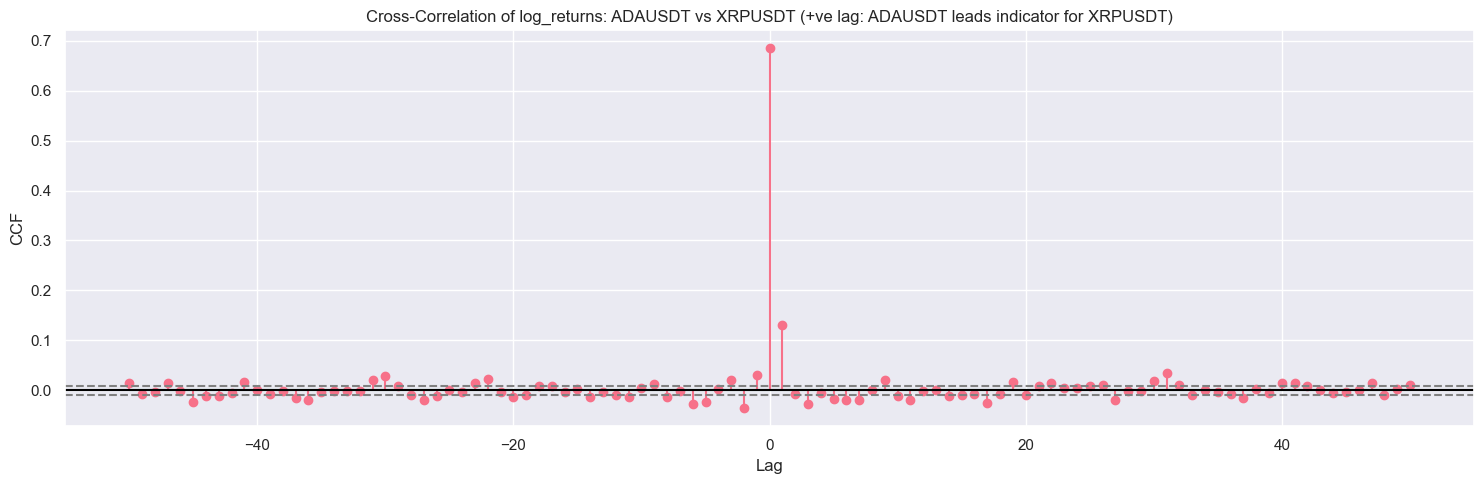


Significant lags between BNBUSDT and BTCUSDT:
BTCUSDT leads BNBUSDT by 42 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 41 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 31 periods (correlation: 0.020)
BTCUSDT leads BNBUSDT by 24 periods (correlation: -0.010)
BTCUSDT leads BNBUSDT by 23 periods (correlation: 0.014)
BTCUSDT leads BNBUSDT by 21 periods (correlation: -0.012)
BTCUSDT leads BNBUSDT by 16 periods (correlation: -0.021)
BTCUSDT leads BNBUSDT by 15 periods (correlation: 0.014)
BTCUSDT leads BNBUSDT by 13 periods (correlation: -0.026)
BTCUSDT leads BNBUSDT by 12 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 8 periods (correlation: 0.013)
BTCUSDT leads BNBUSDT by 7 periods (correlation: 0.015)
BTCUSDT leads BNBUSDT by 6 periods (correlation: -0.013)
BTCUSDT leads BNBUSDT by 1 periods (correlation: 0.019)
BNBUSDT leads BTCUSDT by 1 periods (correlation: 0.013)
BNBUSDT leads BTCUSDT by 2 periods (correlation: -0.034)
BNBUSDT leads BTCUSDT by 4 periods (corre

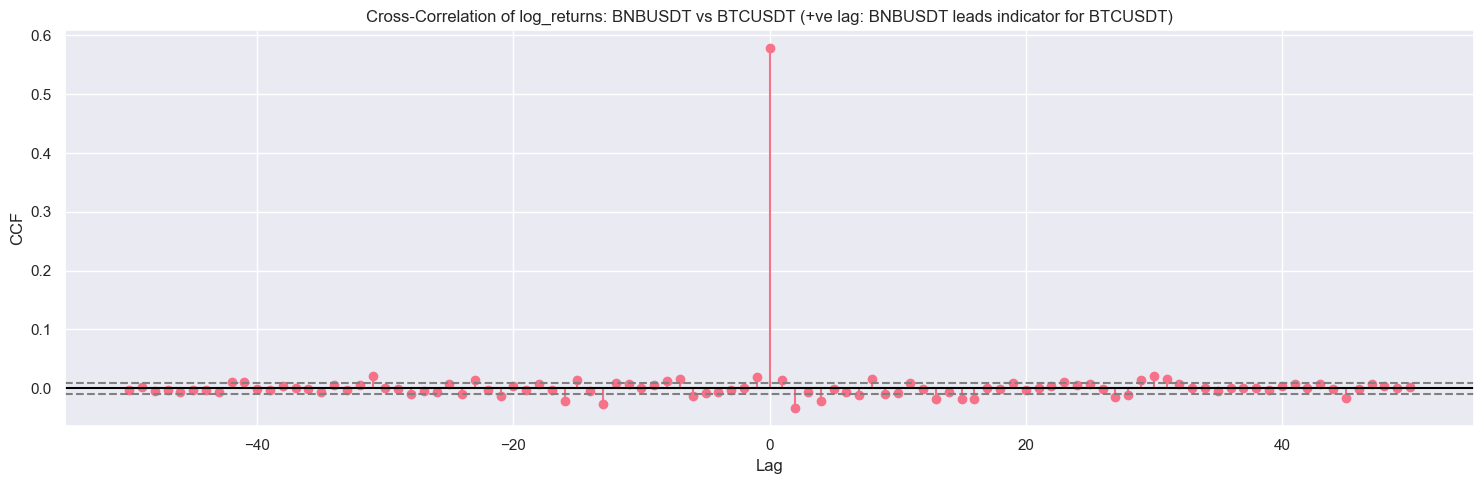


Significant lags between BNBUSDT and DOGEUSDT:
DOGEUSDT leads BNBUSDT by 47 periods (correlation: -0.013)
DOGEUSDT leads BNBUSDT by 46 periods (correlation: -0.022)
DOGEUSDT leads BNBUSDT by 41 periods (correlation: 0.012)
DOGEUSDT leads BNBUSDT by 38 periods (correlation: -0.018)
DOGEUSDT leads BNBUSDT by 31 periods (correlation: 0.026)
DOGEUSDT leads BNBUSDT by 27 periods (correlation: -0.027)
DOGEUSDT leads BNBUSDT by 26 periods (correlation: 0.022)
DOGEUSDT leads BNBUSDT by 23 periods (correlation: 0.009)
DOGEUSDT leads BNBUSDT by 22 periods (correlation: 0.010)
DOGEUSDT leads BNBUSDT by 16 periods (correlation: -0.027)
DOGEUSDT leads BNBUSDT by 13 periods (correlation: -0.040)
DOGEUSDT leads BNBUSDT by 7 periods (correlation: 0.021)
DOGEUSDT leads BNBUSDT by 6 periods (correlation: -0.028)
DOGEUSDT leads BNBUSDT by 5 periods (correlation: -0.016)
DOGEUSDT leads BNBUSDT by 4 periods (correlation: -0.010)
DOGEUSDT leads BNBUSDT by 2 periods (correlation: -0.014)
DOGEUSDT leads BNBU

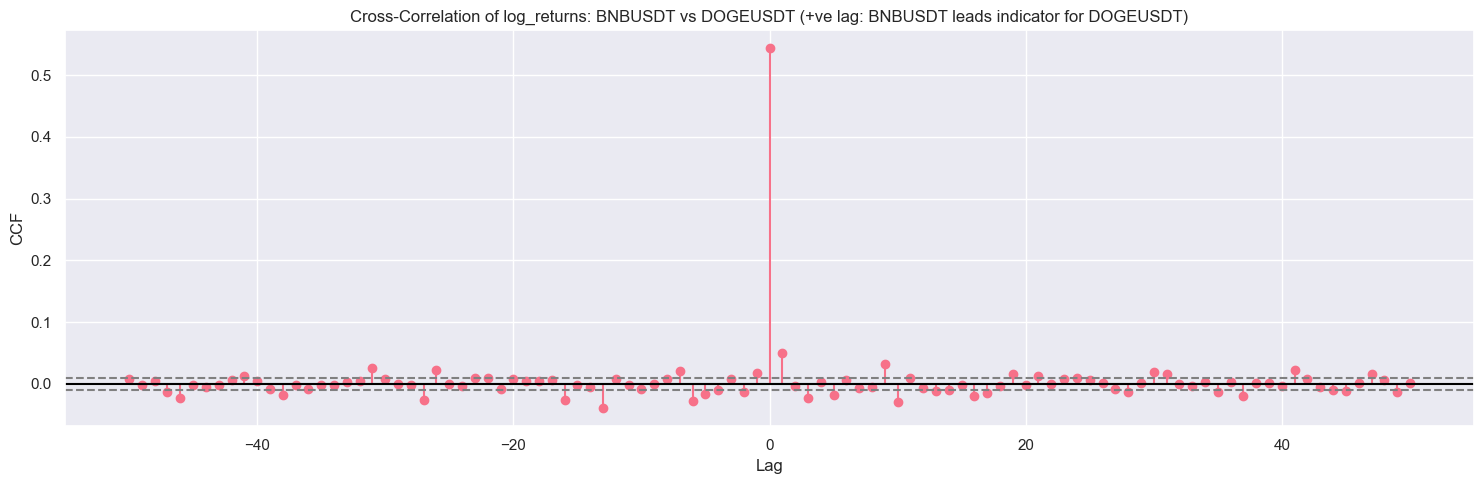


Significant lags between BNBUSDT and ETHUSDT:
ETHUSDT leads BNBUSDT by 46 periods (correlation: -0.014)
ETHUSDT leads BNBUSDT by 42 periods (correlation: 0.011)
ETHUSDT leads BNBUSDT by 31 periods (correlation: 0.020)
ETHUSDT leads BNBUSDT by 27 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 23 periods (correlation: 0.016)
ETHUSDT leads BNBUSDT by 16 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 13 periods (correlation: -0.028)
ETHUSDT leads BNBUSDT by 10 periods (correlation: -0.010)
ETHUSDT leads BNBUSDT by 8 periods (correlation: 0.013)
ETHUSDT leads BNBUSDT by 7 periods (correlation: 0.022)
ETHUSDT leads BNBUSDT by 6 periods (correlation: -0.018)
ETHUSDT leads BNBUSDT by 1 periods (correlation: 0.010)
BNBUSDT leads ETHUSDT by 1 periods (correlation: 0.017)
BNBUSDT leads ETHUSDT by 2 periods (correlation: -0.021)
BNBUSDT leads ETHUSDT by 4 periods (correlation: -0.024)
BNBUSDT leads ETHUSDT by 8 periods (correlation: 0.009)
BNBUSDT leads ETHUSDT by 13 periods (corr

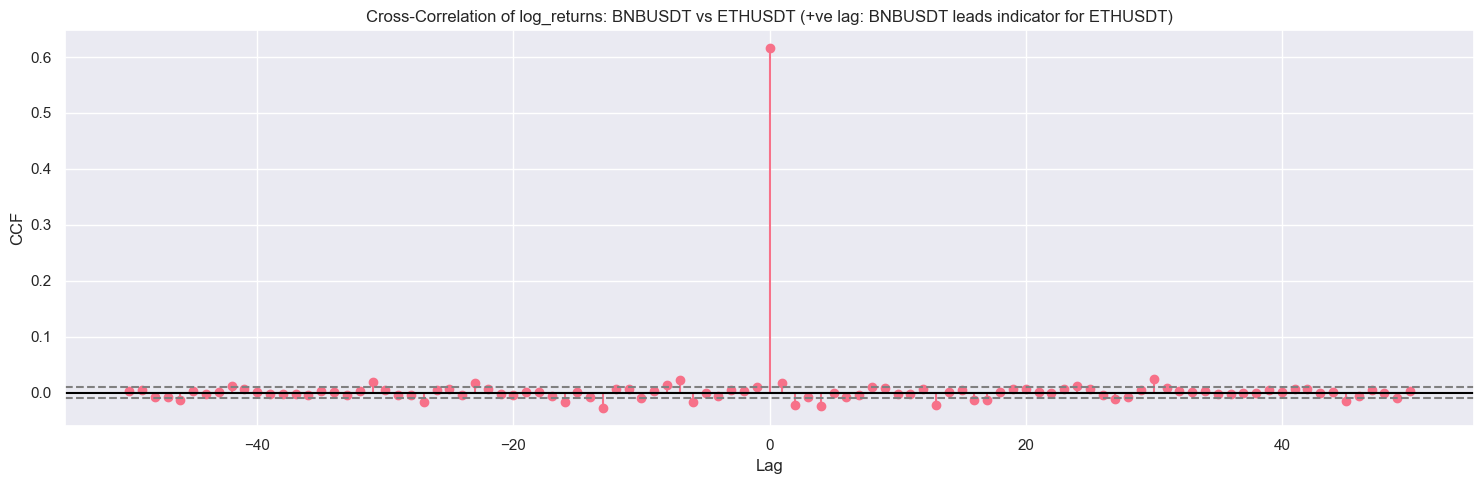


Significant lags between BNBUSDT and XRPUSDT:
XRPUSDT leads BNBUSDT by 50 periods (correlation: 0.021)
XRPUSDT leads BNBUSDT by 46 periods (correlation: -0.037)
XRPUSDT leads BNBUSDT by 45 periods (correlation: -0.019)
XRPUSDT leads BNBUSDT by 41 periods (correlation: 0.019)
XRPUSDT leads BNBUSDT by 39 periods (correlation: -0.012)
XRPUSDT leads BNBUSDT by 38 periods (correlation: -0.021)
XRPUSDT leads BNBUSDT by 37 periods (correlation: -0.014)
XRPUSDT leads BNBUSDT by 31 periods (correlation: 0.022)
XRPUSDT leads BNBUSDT by 30 periods (correlation: 0.025)
XRPUSDT leads BNBUSDT by 29 periods (correlation: 0.012)
XRPUSDT leads BNBUSDT by 28 periods (correlation: -0.011)
XRPUSDT leads BNBUSDT by 27 periods (correlation: -0.022)
XRPUSDT leads BNBUSDT by 23 periods (correlation: 0.023)
XRPUSDT leads BNBUSDT by 22 periods (correlation: 0.015)
XRPUSDT leads BNBUSDT by 19 periods (correlation: -0.010)
XRPUSDT leads BNBUSDT by 18 periods (correlation: 0.010)
XRPUSDT leads BNBUSDT by 16 perio

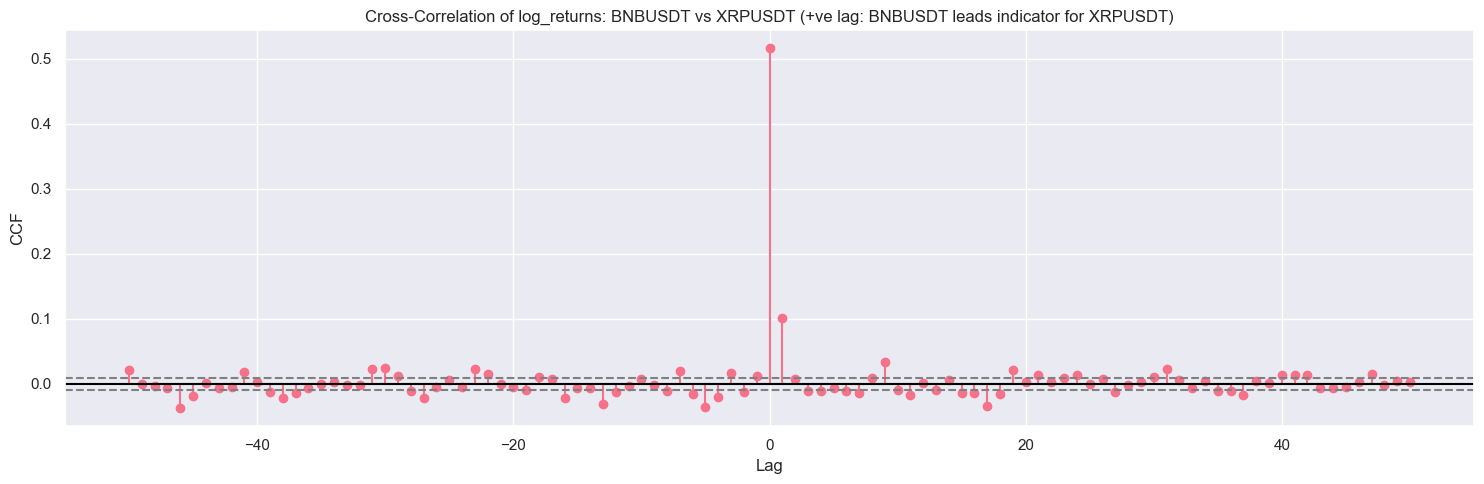


Significant lags between BTCUSDT and DOGEUSDT:
DOGEUSDT leads BTCUSDT by 48 periods (correlation: 0.010)
DOGEUSDT leads BTCUSDT by 44 periods (correlation: -0.013)
DOGEUSDT leads BTCUSDT by 32 periods (correlation: 0.010)
DOGEUSDT leads BTCUSDT by 31 periods (correlation: 0.017)
DOGEUSDT leads BTCUSDT by 30 periods (correlation: 0.017)
DOGEUSDT leads BTCUSDT by 27 periods (correlation: -0.018)
DOGEUSDT leads BTCUSDT by 17 periods (correlation: 0.014)
DOGEUSDT leads BTCUSDT by 16 periods (correlation: -0.013)
DOGEUSDT leads BTCUSDT by 15 periods (correlation: -0.011)
DOGEUSDT leads BTCUSDT by 14 periods (correlation: -0.020)
DOGEUSDT leads BTCUSDT by 13 periods (correlation: -0.019)
DOGEUSDT leads BTCUSDT by 8 periods (correlation: 0.027)
DOGEUSDT leads BTCUSDT by 7 periods (correlation: -0.012)
DOGEUSDT leads BTCUSDT by 6 periods (correlation: -0.029)
DOGEUSDT leads BTCUSDT by 5 periods (correlation: -0.016)
DOGEUSDT leads BTCUSDT by 4 periods (correlation: -0.010)
DOGEUSDT leads BTCU

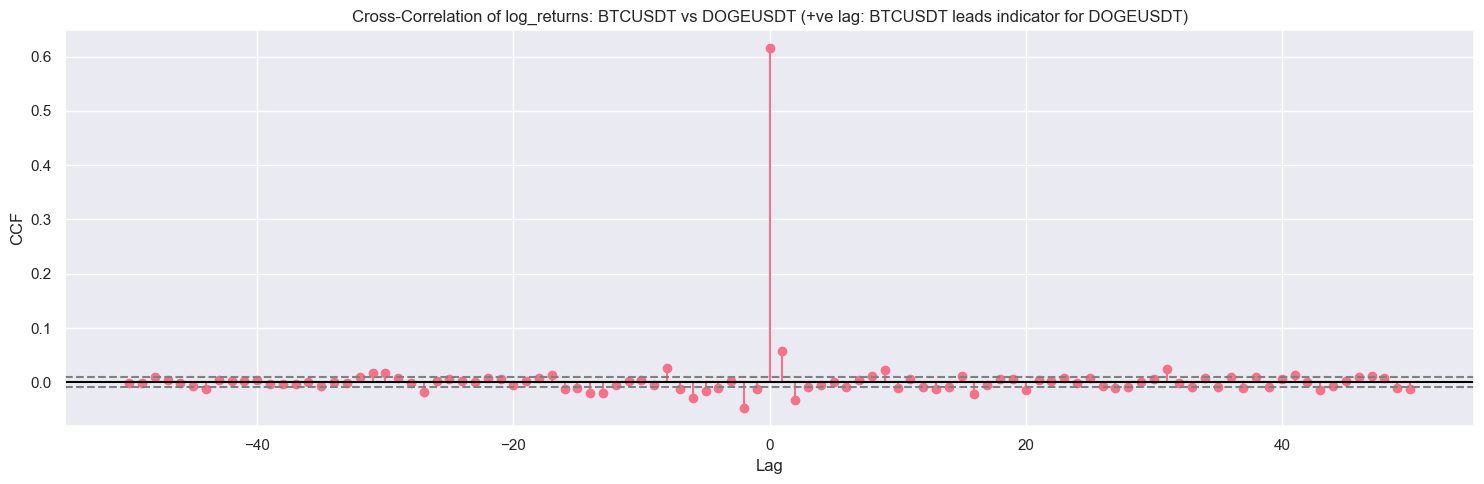


Significant lags between BTCUSDT and ETHUSDT:
ETHUSDT leads BTCUSDT by 42 periods (correlation: 0.014)
ETHUSDT leads BTCUSDT by 33 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 31 periods (correlation: 0.017)
ETHUSDT leads BTCUSDT by 27 periods (correlation: -0.019)
ETHUSDT leads BTCUSDT by 26 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 22 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 20 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 16 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 15 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 14 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 13 periods (correlation: -0.019)
ETHUSDT leads BTCUSDT by 12 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 11 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 9 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 8 periods (correlation: 0.016)
ETHUSDT leads BTCUSDT by 6 periods (correlation: -0.018)
ETHUSDT leads BTCUSDT by 4 period

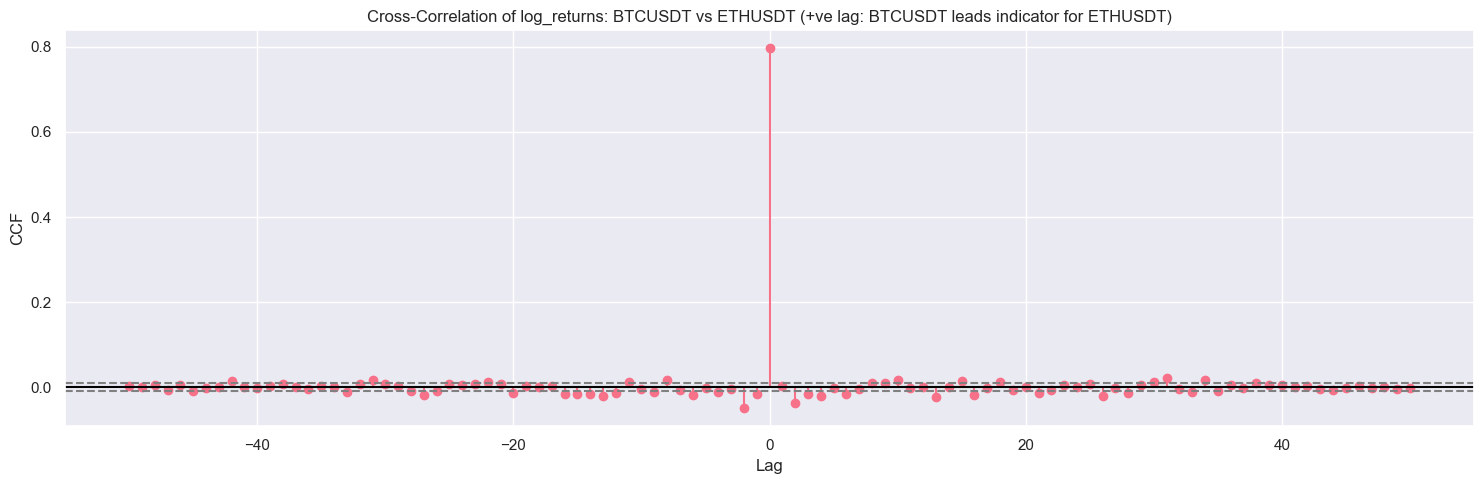


Significant lags between BTCUSDT and XRPUSDT:
XRPUSDT leads BTCUSDT by 50 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 45 periods (correlation: -0.015)
XRPUSDT leads BTCUSDT by 44 periods (correlation: -0.012)
XRPUSDT leads BTCUSDT by 31 periods (correlation: 0.012)
XRPUSDT leads BTCUSDT by 30 periods (correlation: 0.027)
XRPUSDT leads BTCUSDT by 29 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 27 periods (correlation: -0.015)
XRPUSDT leads BTCUSDT by 26 periods (correlation: -0.011)
XRPUSDT leads BTCUSDT by 23 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 22 periods (correlation: 0.009)
XRPUSDT leads BTCUSDT by 17 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 15 periods (correlation: -0.012)
XRPUSDT leads BTCUSDT by 14 periods (correlation: -0.016)
XRPUSDT leads BTCUSDT by 13 periods (correlation: -0.014)
XRPUSDT leads BTCUSDT by 12 periods (correlation: -0.017)
XRPUSDT leads BTCUSDT by 10 periods (correlation: 0.015)
XRPUSDT leads BTCUSDT by 8 period

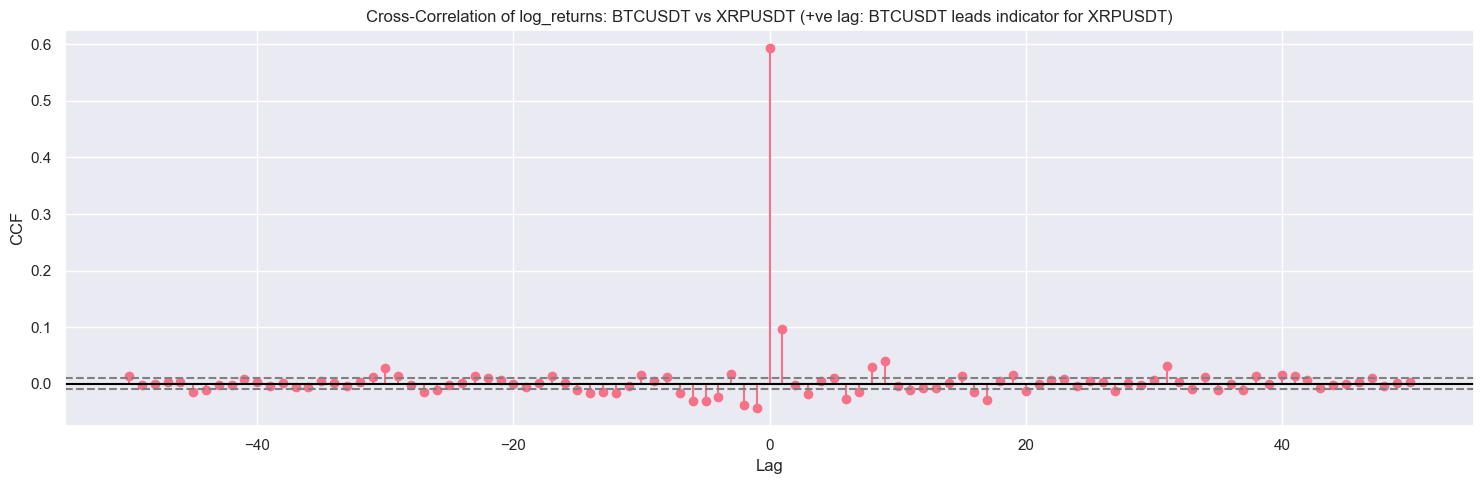


Significant lags between DOGEUSDT and ETHUSDT:
ETHUSDT leads DOGEUSDT by 47 periods (correlation: 0.010)
ETHUSDT leads DOGEUSDT by 43 periods (correlation: -0.010)
ETHUSDT leads DOGEUSDT by 38 periods (correlation: 0.009)
ETHUSDT leads DOGEUSDT by 37 periods (correlation: -0.013)
ETHUSDT leads DOGEUSDT by 34 periods (correlation: 0.013)
ETHUSDT leads DOGEUSDT by 31 periods (correlation: 0.021)
ETHUSDT leads DOGEUSDT by 30 periods (correlation: 0.014)
ETHUSDT leads DOGEUSDT by 27 periods (correlation: -0.018)
ETHUSDT leads DOGEUSDT by 22 periods (correlation: 0.012)
ETHUSDT leads DOGEUSDT by 20 periods (correlation: -0.025)
ETHUSDT leads DOGEUSDT by 16 periods (correlation: -0.013)
ETHUSDT leads DOGEUSDT by 14 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 13 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 10 periods (correlation: -0.032)
ETHUSDT leads DOGEUSDT by 9 periods (correlation: 0.035)
ETHUSDT leads DOGEUSDT by 5 periods (correlation: -0.009)
ETHUSDT leads DOG

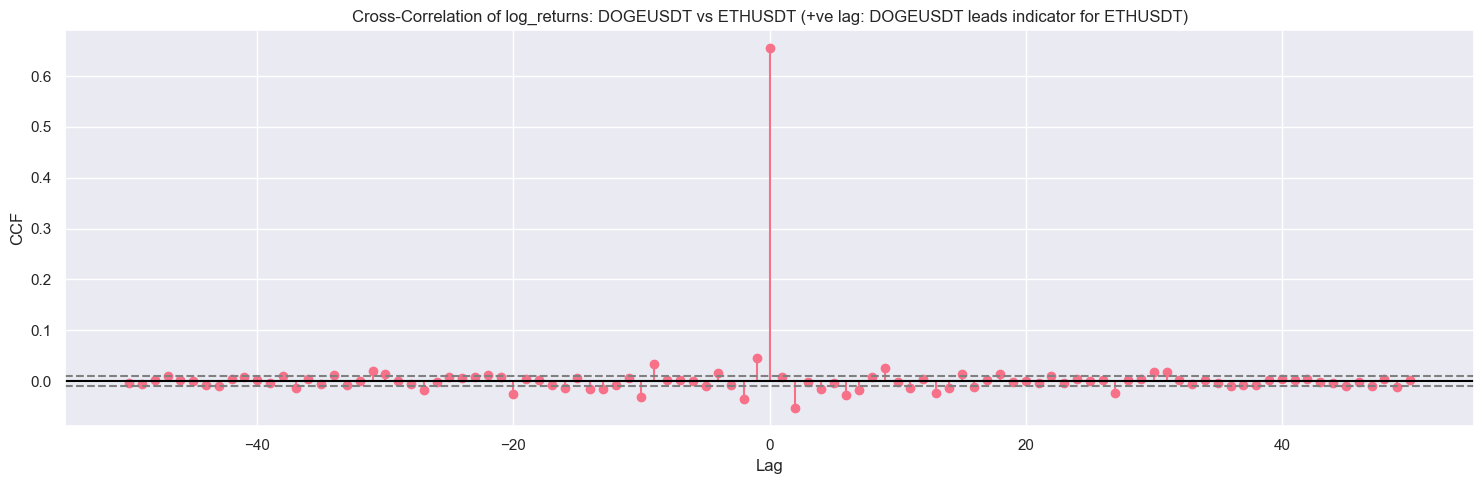


Significant lags between DOGEUSDT and XRPUSDT:
XRPUSDT leads DOGEUSDT by 50 periods (correlation: 0.012)
XRPUSDT leads DOGEUSDT by 49 periods (correlation: -0.014)
XRPUSDT leads DOGEUSDT by 43 periods (correlation: -0.013)
XRPUSDT leads DOGEUSDT by 41 periods (correlation: 0.020)
XRPUSDT leads DOGEUSDT by 39 periods (correlation: -0.013)
XRPUSDT leads DOGEUSDT by 37 periods (correlation: -0.020)
XRPUSDT leads DOGEUSDT by 36 periods (correlation: -0.011)
XRPUSDT leads DOGEUSDT by 31 periods (correlation: 0.016)
XRPUSDT leads DOGEUSDT by 30 periods (correlation: 0.023)
XRPUSDT leads DOGEUSDT by 28 periods (correlation: -0.010)
XRPUSDT leads DOGEUSDT by 27 periods (correlation: -0.020)
XRPUSDT leads DOGEUSDT by 23 periods (correlation: 0.011)
XRPUSDT leads DOGEUSDT by 22 periods (correlation: 0.027)
XRPUSDT leads DOGEUSDT by 21 periods (correlation: 0.013)
XRPUSDT leads DOGEUSDT by 20 periods (correlation: -0.017)
XRPUSDT leads DOGEUSDT by 18 periods (correlation: 0.011)
XRPUSDT leads DO

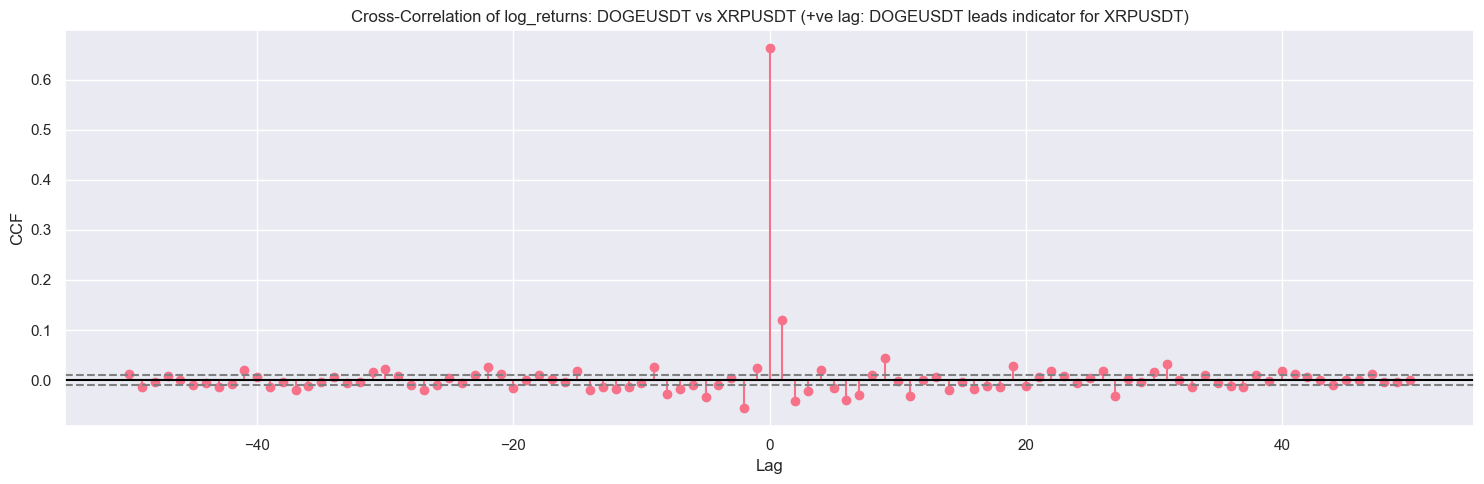


Significant lags between ETHUSDT and XRPUSDT:
XRPUSDT leads ETHUSDT by 50 periods (correlation: 0.012)
XRPUSDT leads ETHUSDT by 49 periods (correlation: -0.013)
XRPUSDT leads ETHUSDT by 48 periods (correlation: -0.010)
XRPUSDT leads ETHUSDT by 45 periods (correlation: -0.019)
XRPUSDT leads ETHUSDT by 41 periods (correlation: 0.010)
XRPUSDT leads ETHUSDT by 37 periods (correlation: -0.013)
XRPUSDT leads ETHUSDT by 36 periods (correlation: -0.014)
XRPUSDT leads ETHUSDT by 31 periods (correlation: 0.015)
XRPUSDT leads ETHUSDT by 30 periods (correlation: 0.031)
XRPUSDT leads ETHUSDT by 29 periods (correlation: 0.016)
XRPUSDT leads ETHUSDT by 27 periods (correlation: -0.014)
XRPUSDT leads ETHUSDT by 26 periods (correlation: -0.015)
XRPUSDT leads ETHUSDT by 22 periods (correlation: 0.013)
XRPUSDT leads ETHUSDT by 19 periods (correlation: -0.012)
XRPUSDT leads ETHUSDT by 18 periods (correlation: 0.011)
XRPUSDT leads ETHUSDT by 15 periods (correlation: 0.017)
XRPUSDT leads ETHUSDT by 13 perio

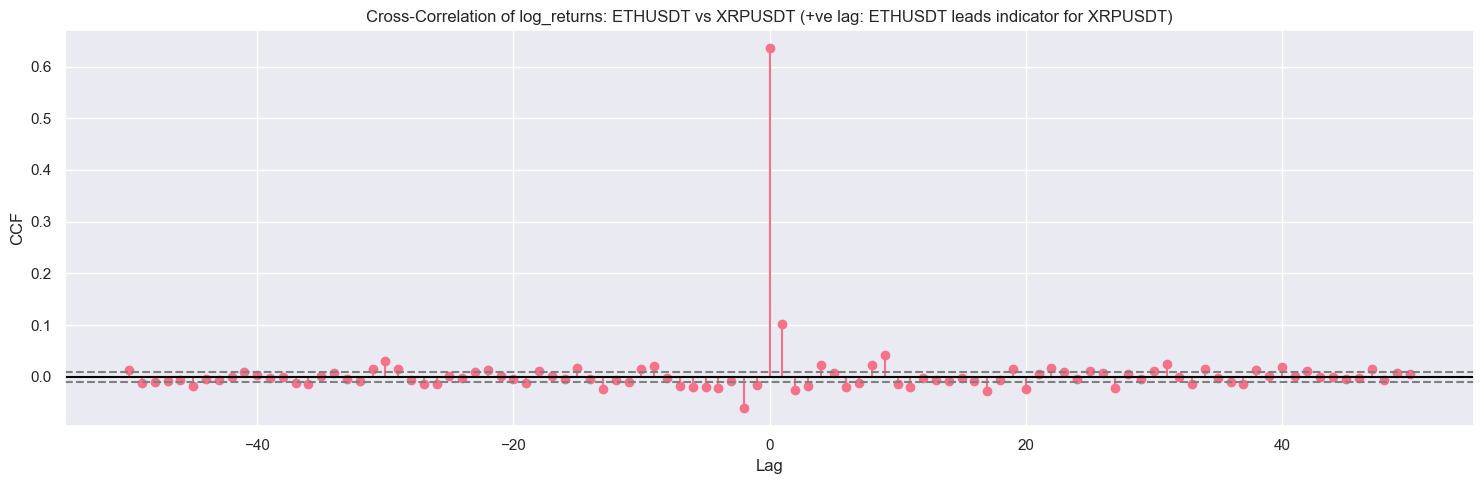

Summary of Strongest Lead-Lag Relationships:
      Leader    Lagger  Lag (minutes)  Correlation
10   BTCUSDT   ETHUSDT              0     0.796184
3    ADAUSDT   ETHUSDT              0     0.751736
1    ADAUSDT   BTCUSDT              0     0.716196
2    ADAUSDT  DOGEUSDT              0     0.695701
4    ADAUSDT   XRPUSDT              0     0.684802
13  DOGEUSDT   XRPUSDT              0     0.662347
12  DOGEUSDT   ETHUSDT              0     0.654348
14   ETHUSDT   XRPUSDT              0     0.635185
0    ADAUSDT   BNBUSDT              0     0.618289
7    BNBUSDT   ETHUSDT              0     0.615470
9    BTCUSDT  DOGEUSDT              0     0.615023
11   BTCUSDT   XRPUSDT              0     0.592986
5    BNBUSDT   BTCUSDT              0     0.577927
6    BNBUSDT  DOGEUSDT              0     0.543138
8    BNBUSDT   XRPUSDT              0     0.515526


In [68]:
# Load data
all_data, returns_data = load_and_prepare_data()

# Plot ACF analysis for log returns
print("ACF Analysis of Log Returns")
plot_acf_analysis(returns_data, diff_type="log_returns")

# Plot CCF analysis for log returns
print("\nCCF Analysis of Log Returns")
plot_ccf_analysis(returns_data, diff_type="log_returns")


In [76]:
# Show summary of lead-lag relationships
summary_df = create_lead_lag_summary(returns_data)
print("Summary of Strongest Lead-Lag Relationships:")
print(summary_df)


Summary of Strongest Lead-Lag Relationships:
      Leader    Lagger  Lag (minutes)  Correlation
4    ADAUSDT   XRPUSDT              0     0.129604
13  DOGEUSDT   XRPUSDT              0     0.120259
14   ETHUSDT   XRPUSDT              0     0.101110
8    BNBUSDT   XRPUSDT              0     0.100618
11   BTCUSDT   XRPUSDT              0     0.096644
9    BTCUSDT  DOGEUSDT              0     0.058017
12  DOGEUSDT   ETHUSDT              1    -0.053214
2    ADAUSDT  DOGEUSDT              0     0.052535
1    ADAUSDT   BTCUSDT              1    -0.051754
6    BNBUSDT  DOGEUSDT              0     0.050441
10   ETHUSDT   BTCUSDT              2    -0.048976
0    BNBUSDT   ADAUSDT              1     0.045379
3    ADAUSDT   ETHUSDT              1    -0.038502
5    BNBUSDT   BTCUSDT              1    -0.033925
7    ETHUSDT   BNBUSDT             13    -0.028151


### Vol Analysis

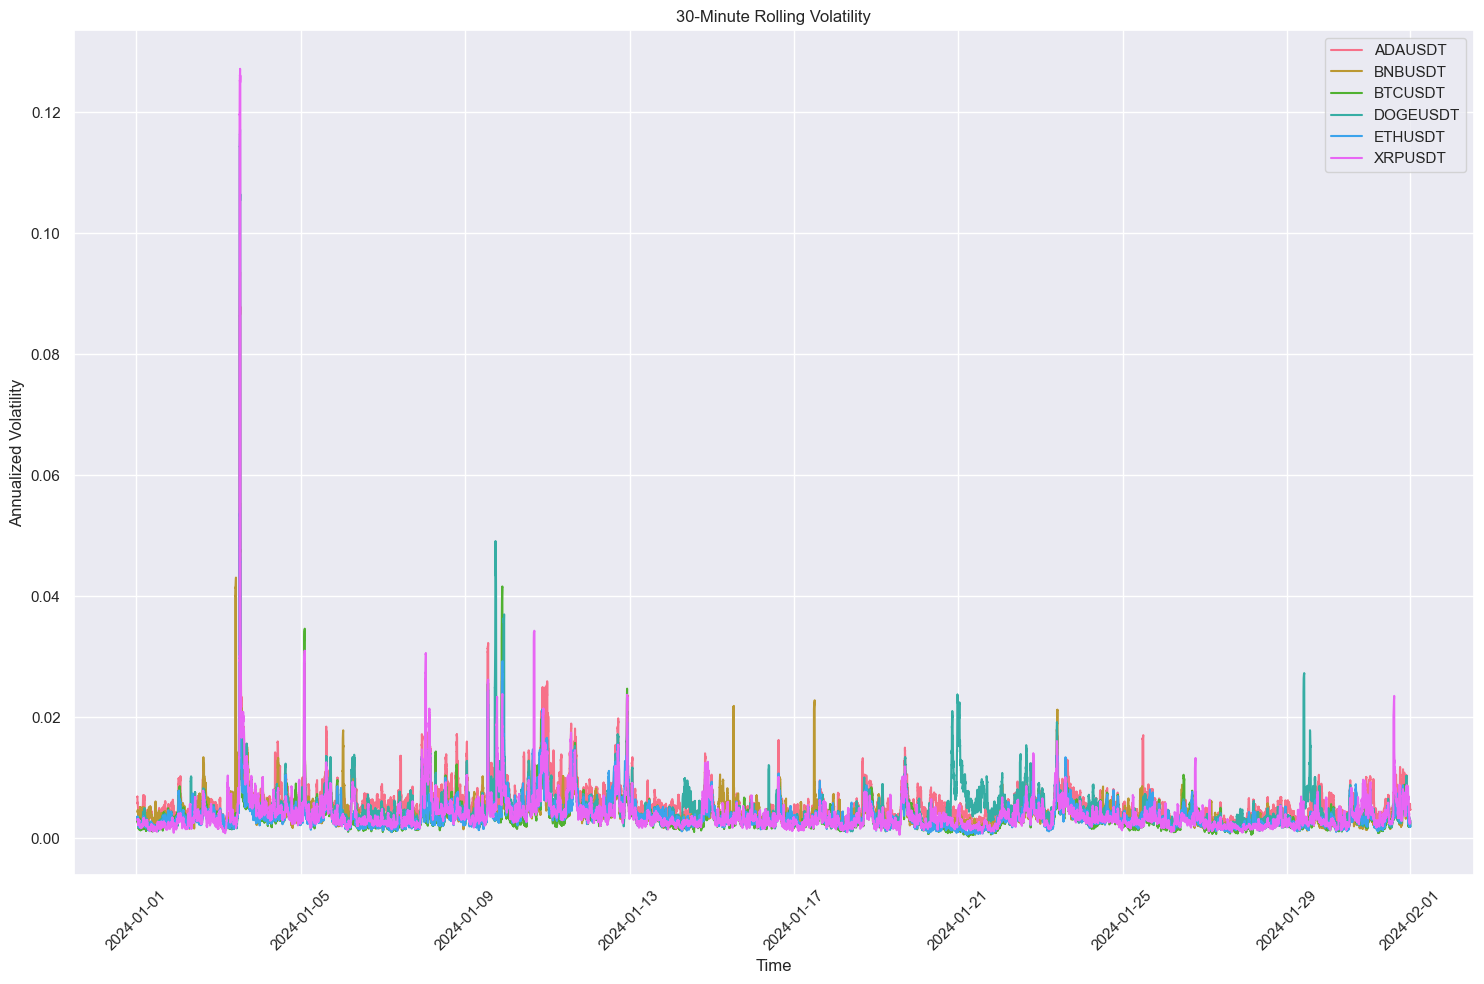

In [77]:
# Volatility Analysis
# Calculate rolling volatility (30-minute window)
plt.figure(figsize=(15, 10))
for symbol, returns in returns_data.items():
    vol = returns['log_returns'].rolling(window=30).std() * np.sqrt(30)
    plt.plot(returns['timestamp'], vol, label=symbol)

plt.title('30-Minute Rolling Volatility')
plt.xlabel('Time')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Returns Distribution

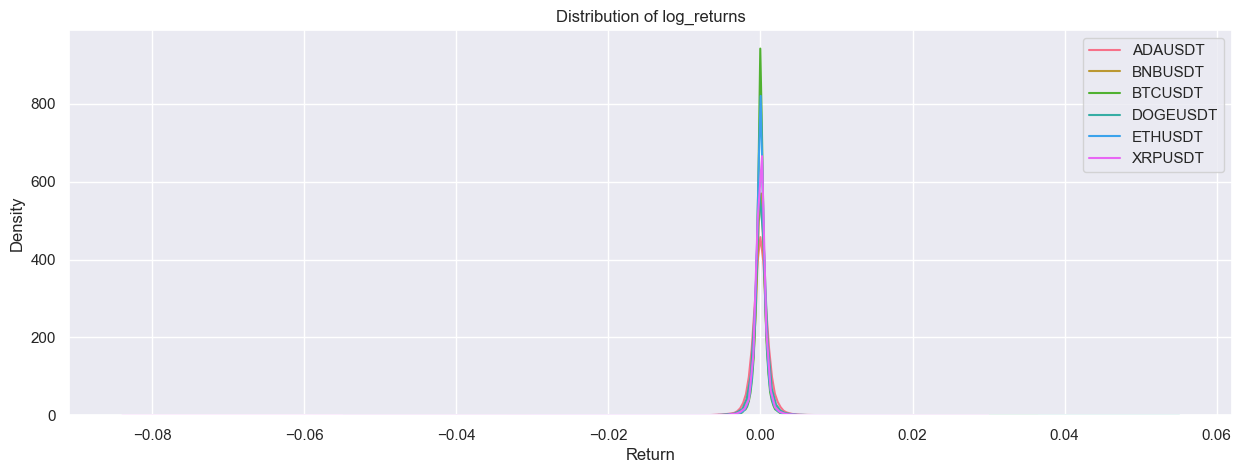

In [ ]:
plot_returns_distribution(returns_data, "log_returns")

In [ ]:
# Load data
returns_data = load_and_prepare_data()

# Plot QQ plots vs normal distribution
print("QQ Plots vs Normal Distribution")
plot_qq_normal(returns_data)

# Plot QQ plots between pairs
print("\nQQ Plots Between Cryptocurrency Pairs")
plot_qq_pairs(returns_data)

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    combined_returns.corr(),
    annot=True,
    cmap='RdYlBu',
    center=0,
    fmt='.2f'
)
plt.title('Correlation Heatmap of Crypto Returns')
plt.tight_layout()
plt.show()